## 1. Pipeline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = 50

### 1.0 Daten einlesen

In [3]:
df = pd.read_csv("../Data/immo_data.csv")
desc = pd.read_csv("../Data/immo_data_column_description.csv")

### 1.1 Daten eingrenzen

In [4]:
df_reduced = df.drop(["scoutId", "houseNumber", "geo_bln", "geo_krs", "geo_plz", "date", "telekomHybridUploadSpeed"], axis=1, errors="ignore")
categorical_columns = df_reduced.select_dtypes(exclude=np.number).columns

for c in categorical_columns:
    if len(df_reduced[c].unique()) > 50:
        df_reduced.drop(c, axis=1, inplace=True)

### 1.2 Ausreißer entfernen

In [5]:
interesting_columns = ["serviceCharge", "totalRent", "yearConstructed", "noParkSpaces", "baseRent", "livingSpace", "noRooms", "numberOfFloors", "heatingCosts", "lastRefurbish"]
upper_limits = df[interesting_columns].quantile(0.995)
lower_limits = df[interesting_columns].quantile(0.005)

for col in interesting_columns:
    df_reduced[col] = df[((df[col] < upper_limits[col]) & (df[col] > lower_limits[col])) | df[col].isna()][col]

df_reduced = df_reduced[df_reduced["baseRent"].isna() == False]


### 1.3 Daten auffüllen (Imputation)

In [6]:
from sklearn.impute import SimpleImputer

red_num = df_reduced.select_dtypes("number").columns
red_qua = df_reduced.select_dtypes("object").columns

imp_mean = SimpleImputer(missing_values=np.nan, strategy= 'mean').fit(df_reduced[red_num])
imp_most = SimpleImputer(missing_values=np.nan, strategy= 'most_frequent').fit(df_reduced[red_qua])

df_reduced[red_num] = imp_mean.transform(df_reduced[red_num])
df_reduced[red_qua] = imp_most.transform(df_reduced[red_qua])

df_reduced = pd.concat([pd.get_dummies(df_reduced[red_qua]),df_reduced], axis=1)
df_reduced = df_reduced.drop(red_qua, axis=1, errors="ignore")

### 1.4 Trainings- und Testset erstellen
Bevor wir die Daten weiter bearbeiten, spalten wir sie in Trainings- und Testset auf.

In [7]:
from sklearn.model_selection import train_test_split
X = df_reduced.drop("baseRent", axis=1)
y = df_reduced["baseRent"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
feature_names = (names for names in X)

### 1.5 Daten skalieren

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### 1.6 Modelltraining

In [9]:
from sklearn import linear_model
m_lr = linear_model.LinearRegression().fit(X_train,y_train)
y_train_pred = m_lr.predict(X_train)
y_test_pred = m_lr.predict(X_test)

### 1.7 Modellevaluation

In [10]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2_train =  r2_score(y_train, y_train_pred)
mse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
mae_train = np.sqrt(mean_absolute_error(y_train, y_train_pred))
r2_test = r2_score(y_test, y_test_pred)
mse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)) 
mae_test = np.sqrt(mean_squared_error(y_test, y_test_pred)) 

print(f"R² Trainingsdaten: {r2_train}")
print(f"Mean squared error Trainingsdaten: {mse_train}")
print(f"Mean absolute error Trainingsdaten: {mae_train}")
print(f"R² Testdaten: {r2_test}")
print(f"Mean squared error Testdaten: {mse_test}")
print(f"Mean absolute error Testdaten: {mae_test}")

# Problemdimensionen
print(f"N={X_train.shape[0]}, p={X_train.shape[1]}, ||w||_2 = {np.linalg.norm(m_lr.coef_)}")

# Ausgabe der ersten 10 Koeffizienten, absteigend nach Absolutbetrag skaliert
coefficients_lr = pd.DataFrame({"Feature Name": feature_names, "Coefficient": m_lr.coef_})

R² Trainingsdaten: 0.9078441562880617
Mean squared error Trainingsdaten: 128.1597699674472
Mean absolute error Trainingsdaten: 9.02606244787048
R² Testdaten: 0.9117796379723117
Mean squared error Testdaten: 125.56397620379497
Mean absolute error Testdaten: 125.56397620379497
N=178293, p=95, ||w||_2 = 33686315252399.43


Das Ergebnis der multiplen linearen Regression ist nicht so einfach zu visualisieren. Erzeugen Sie eine Visualisierung als Scatterplot zwischen der Größe der Wohnung und der Kaltmiete (blau) bzw. der vorhergesagten Kaltmiete (rot) auf Basis des Testsets. Für weitere Einsichten gerne auch weitere Scatterplots.

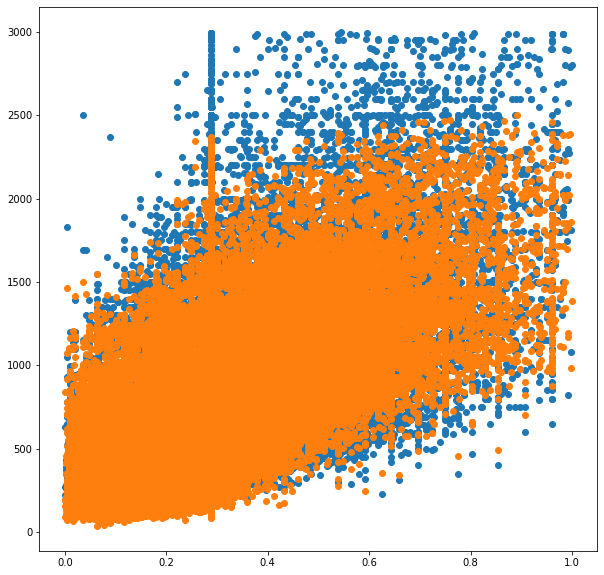

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(X_test.T[81], y_test)
plt.scatter(X_test.T[81], y_test_pred)

plt.show()